In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch
import seaborn as sns
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import confusion_matrix
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
import sys
sys.path.insert(0, '../src/')
from torch_utils import load_model
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.dpi'] = 100

plt.style.use("seaborn-colorblind")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install adjustText

In [3]:
from adjustText import adjust_text

### Define parameters

In [2]:
num_batches = 10  # num batches epoch
lr = 1e-3
o = "Adam"
l = "CrossEntropyLoss"
lr_decay_factor = 0.9
lr_decay_patience = 100
max_epochs = 200000
a = "ReLU"
n_layers = 3
n_units = 350  # generally 10 to 512 units
n_units2 = 350
n_units3 = 350
n_units4 = 128

In [20]:
def prepareData(data, run):
    # Pre-processing
    X, y = data[:, :-2], data[:, -2]

    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    #y = F.one_hot(y, num_classes=7)  # One-hot-encoding
    if run == 'O3a':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    if run == 'O3b':
        X_test, y_test = X, y
    return X_test, y_test


def predictions(data, model, threshold=0.9):
    # Pre-processing
    X, y = data, np.ones(len(data))
    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    unknown_data = TensorDataset(X, y)
    unknown_dataloader = DataLoader(unknown_data, batch_size=len(unknown_data))

    k = 0
    for x_, y_ in unknown_dataloader:
        # Forward pass
        pred = model(x_)
        # get the predicted labels from the probabilities
        y_pred = nn.Softmax(dim=1)(pred)
        print(len(y_pred))
        pred_labels = list()
        for i in range(len(y_pred)):
            if y_pred[i][0] >= threshold:
                label = 0
            else: 
                # plus one moves the label naming
                label = np.argmax(y_pred[i][1:].detach().numpy()) + 1
            pred_labels.append(label)
        pred_labels = np.asarray(pred_labels)
        pred_labels_max = torch.argmax(y_pred, dim = 1) 
    return y_pred.detach().numpy(), pred_labels, pred_labels_max.detach().numpy()

def ratesInjections(cf_matrix):
    tp, fp, fn, tn = cf_matrix[0, 0],  np.sum(cf_matrix[1:, 0]), np.sum(cf_matrix[0, 1:]), np.sum(cf_matrix[1:, 1:])
    TPR = tp/(tp+fn)
    FPR = fp/(fp+tn)
    return TPR, FPR

def getKnownPredictions(data, run, tw, ifo, threshold=0.5):
    X_test, y_test = prepareData(data, run)
    model = load_model(tw, ifo)
    ypred, label_pred, max_pred = predictions(X_test, model, threshold)
    return ypred

In [4]:
def doubleCoincidence(data1, data2, ifo1, ifo2):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster_times'] >= tmp1['Cluster_times'] - 0.03) & (data2['Cluster_times'] <= tmp1['Cluster_times'] + 0.03) & (data2['Cluster_ID'] == tmp1['Cluster_ID'])]

        if len(tmp2) == 1:
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp

def tripleCoincidence(data1, data2, data3, ifo1, ifo2, ifo3):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2,
             'SNR_'+ifo3, 'Chisq_'+ifo3, 'Mass_1_'+ifo3, 'Mass_2_'+ifo3, 'Spin1z_'+ifo3, 'Spin2z_'+ifo3, 'Class_'+ifo3, 'Num_triggers_'+ifo3, 'Cluster_ID'+ifo3, 'Cluster_times_'+ifo3, 'ProbInj_'+ifo3]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster_times'] >= tmp1['Cluster_times'] - 0.03) & (data2['Cluster_times'] <= tmp1['Cluster_times'] + 0.03)]
        tmp3 = data3.loc[(data3['Cluster_times'] >= tmp1['Cluster_times'] - 0.03) & (data3['Cluster_times'] <= tmp1['Cluster_times'] + 0.03)]

        if (len(tmp2) == 1) and (len(tmp3) == 1):
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]) + list(tmp3.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp

In [5]:
def plot_spectrogram(tmp):
    """
    Plots a spectrogram of a given time series.

    Parameters:
        tmp (array-like): Input time series.

    Returns:
        None
    """

    # Perform q-transform
    q_scan = tmp.q_transform(qrange=[4, 64], frange=[10, 2048],
                             tres=0.002, fres=0.5, whiten=True)

    # Plot spectrogram
    fig, ax = plt.subplots(dpi=120)
    ax.imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5)
    ax.set_yscale('log', base=2)
    ax.set_xscale('linear')
    ax.set_ylabel('Frequency (Hz)', fontsize=14)
    ax.set_xlabel('Time (s)', labelpad=0.1, fontsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=14)
    #cb = ax.colorbar(label='Normalized energy', clim=[0, 25.5])
    plt.show()

In [6]:
def avChirpMass(data, ifo1, ifo2):
    chirp1 = (data['Mass_1_'+ifo1] * data['Mass_2_'+ifo1])**(3/5)/(data['Mass_1_'+ifo1]+tmp['Mass_2_'+data])**(1/5)
    chirp2 = (data['Mass_1_'+ifo2] * data['Mass_2_'+ifo2])**(3/5)/(data['Mass_1_'+ifo2]+tmp['Mass_2_'+data])**(1/5)
    avchirp = (chirp1 + chirp2)/2
    return avchirp

### Losses

H1
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
7980
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
153300
L1
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
6650
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
301700
V1
99.05Acc_V1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2382epochs_10batches.pth
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760
14760


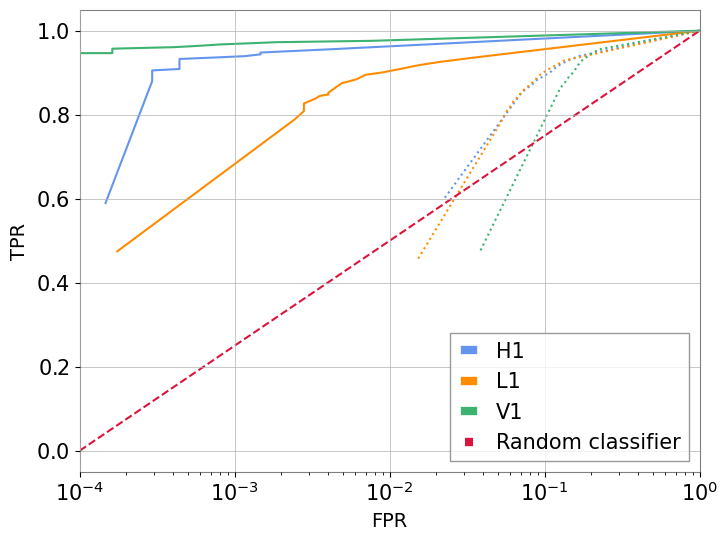

In [25]:
for ifo, color in zip(['H1', 'L1', 'V1'], ['cornflowerblue', 'darkorange', 'mediumseagreen']):
    print(ifo)
    for run in ['O3a', 'O3b']:
        for tw in [0.05]:
            path = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'
            data = np.load(path + "dataset_all_" + ifo + "_bootstrap_" + run + ".npy")
            X_test, y_test = prepareData(data, run)

            # Call models
            model = load_model(tw, ifo)

            tprs, fprs = list(), list()
            for threshold in np.concatenate([np.linspace(0, 0.9, 10), np.linspace(0.9, 1, 10)]):

                ypred, label_pred, max_pred = predictions(X_test, model, threshold)
                df = pd.DataFrame(ypred)
                df['True'], df['Label_pred'], df['Max_pred'] = y_test, label_pred, max_pred
                cf_matrix = confusion_matrix(df['True'], df['Label_pred'])
                TPR, FPR = ratesInjections(cf_matrix)
                tprs.append(TPR)
                fprs.append(FPR)
            if run == 'O3a':
                plt.plot(fprs, tprs, label=ifo, c=color)
            else:
                plt.plot(fprs, tprs, linestyle='dotted', c=color)
plt.xscale('log')
plt.plot([10**-4, 1], [10**-4, 1], c='crimson', linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
#if run == 'O3a':
plt.xlim(10**-4, 1)
#else:
plt.legend()
plt.show()



In [8]:
for ifo in ['H1', 'L1', 'V1']:
    print(ifo)
    for run in ['O3a', 'O3b']:
        for tw in [0.05, 0.1, 0.2, 0.5]:
            path = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'
            data = np.load(path + "dataset_all_" + ifo + "_bootstrap_" + run + ".npy")
            X_test, y_test = prepareData(data, run)

            # Call models
            model = load_model(tw, ifo)

            tprs, fprs = list(), list()
            for threshold in np.concatenate([np.linspace(0, 0.9, 10), np.linspace(0.9, 1, 10)]):

                ypred, label_pred, max_pred = predictions(X_test, model, threshold)
                df = pd.DataFrame(ypred)
                df['True'], df['Label_pred'], df['Max_pred'] = y_test, label_pred, max_pred
                cf_matrix = confusion_matrix(df['True'], df['Label_pred'])
                TPR, FPR = ratesInjections(cf_matrix)
                tprs.append(TPR)
                fprs.append(FPR)
            plt.plot(fprs, tprs, label=r'$t_{w}=$'+str(tw))
            plt.xscale('log')
        plt.plot([10**-4, 1], [10**-4, 1], c='crimson', linestyle='--', label='Random classifier')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        if run == 'O3a':
            plt.xlim(10**-4, 1)
        else:
            plt.xlim(10**-2, 1)
        plt.title('Testing in '+run)
        plt.legend()
        plt.show()


H1
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7980x7 and 6x350)

### Probabilities

In [9]:
tw = 0.05
ifo, run = 'H1', 'O3b'
path = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'
data = np.load(path + "dataset_all_" + ifo + "_bootstrap_" + run + ".npy")
data.shape

(153300, 8)

In [10]:
columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class', 'Num_triggers', 'Cluster_ID', 'Cluster_times']

# Load data input to MLP
dataH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + ".npy")
dataL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + ".npy")
dataV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + ".npy")

print(dataH1.shape)
# Compute predictions
ypredH1, ypredL1, ypredV1 = getKnownPredictions(dataH1[:, :-1], run, tw, 'H1'), getKnownPredictions(dataL1[:, :-1], run, tw, 'L1'), getKnownPredictions(dataV1[:, :-1], run, tw, 'V1')

# Load times
timesH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + "_IDs.npy")
timesL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + "_IDs.npy")
timesV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + "_IDs.npy")

# Merge everything and label
dataH1 = pd.merge(pd.DataFrame(dataH1), pd.DataFrame(timesH1),
                  left_index=True, right_index=True)
dataL1 = pd.merge(pd.DataFrame(dataL1), pd.DataFrame(timesL1),
                  left_index=True, right_index=True)
dataV1 = pd.merge(pd.DataFrame(dataV1), pd.DataFrame(timesV1),
                  left_index=True, right_index=True)
dataH1.columns, dataL1.columns, dataV1.columns = columns, columns, columns

# Merge predictions with data
dataH1, dataL1, dataV1 = pd.DataFrame(dataH1, columns=columns), pd.DataFrame(dataL1, columns=columns), pd.DataFrame(dataV1, columns=columns)
dataH1['ProbInj'], dataL1['ProbInj'], dataV1['ProbInj'] = ypredH1[:, 0], ypredL1[:, 0], ypredV1[:, 0]
dataH1, dataL1, dataV1 = dataH1.loc[dataH1['Class'] == 0], dataL1.loc[dataL1['Class'] == 0], dataV1.loc[dataV1['Class'] == 0]
dataH1, dataL1, dataV1 = dataH1.reset_index(drop=True), dataL1.reset_index(drop=True), dataV1.reset_index(drop=True)


(153300, 8)
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


153300
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
301700
99.05Acc_V1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2382epochs_10batches.pth
175200


In [13]:
def doubleCoincidence(data1, data2, ifo1, ifo2):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster_times'] >= tmp1['Cluster_times'] - 0.03) & (data2['Cluster_times'] <= tmp1['Cluster_times'] + 0.03)]

        if len(tmp2) == 1:
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp
len(doubleCoincidence(dataH1, dataL1, 'H1', 'L1'))

22


8972

22
0.010002374649047852
22
0.027284860610961914
22
0.026447534561157227


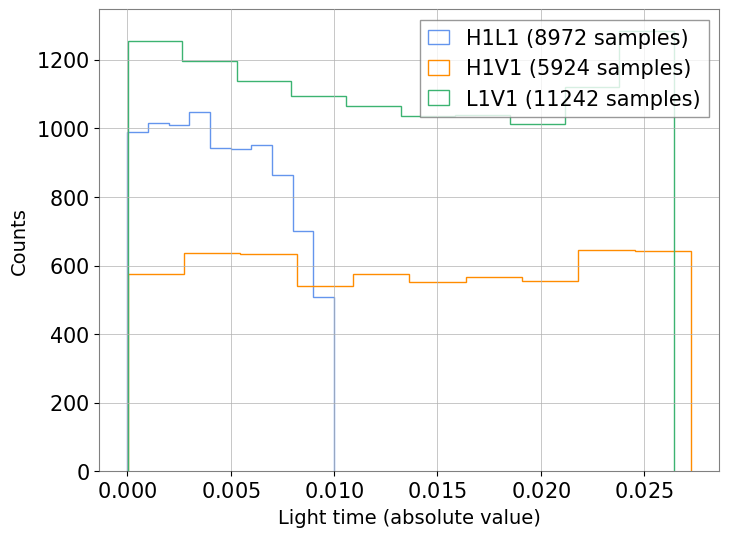

In [27]:
def doubleCoincidence(data1, data2, ifo1, ifo2):
    columns=['SNR_'+ifo1, 'Chisq_'+ifo1, 'Mass_1_'+ifo1, 'Mass_2_'+ifo1, 'Spin1z_'+ifo1, 'Spin2z_'+ifo1, 'Class_'+ifo1, 'Num_triggers_'+ifo1, 'Cluster_ID'+ifo1, 'Cluster_times_'+ifo1, 'ProbInj_'+ifo1, 
             'SNR_'+ifo2, 'Chisq_'+ifo2, 'Mass_1_'+ifo2, 'Mass_2_'+ifo2, 'Spin1z_'+ifo2, 'Spin2z_'+ifo2, 'Class_'+ifo2, 'Num_triggers_'+ifo2, 'Cluster_ID'+ifo2, 'Cluster_times_'+ifo2, 'ProbInj_'+ifo2]
    print(len(columns))
    tmps = list()
    for i in range(len(data1)): 
        tmp1 = data1.iloc[i]
        tmp2 = data2.loc[(data2['Cluster_times'] >= tmp1['Cluster_times'] - 10) & (data2['Cluster_times'] <= tmp1['Cluster_times'] + 10) & (data2['Cluster_ID'] == tmp1['Cluster_ID'])]

        if len(tmp2) == 1:
            tmps.append(list(tmp1.values)+ list(tmp2.values[0]))

    tmp = pd.DataFrame(tmps, columns=columns)
    return tmp

for data1, data2, ifo1, ifo2, c in zip([dataH1, dataH1, dataL1], [dataL1, dataV1, dataV1], ['H1', 'H1', 'L1'],
                                       ['L1', 'V1', 'V1'], ['cornflowerblue', 'darkorange', 'mediumseagreen']):
    tmp = doubleCoincidence(data1, data2, ifo1, ifo2)
    plt.hist(np.abs(tmp['Cluster_times_'+ifo1] - tmp['Cluster_times_'+ifo2]),
             label=ifo1+ifo2 + ' ('+str(len(tmp))+' samples)', histtype='step', color=c)
    print(max(np.abs(tmp['Cluster_times_'+ifo1] - tmp['Cluster_times_'+ifo2])))
    plt.xlabel('Light time (absolute value)'), plt.ylabel('Counts')
    plt.legend()

In [ ]:
dataH1L1 = doubleCoincidence(dataH1, dataL1, 'H1', 'L1')
dataH1V1 = doubleCoincidence(dataH1, dataV1, 'H1', 'V1')
dataL1V1 = doubleCoincidence(dataL1, dataV1, 'L1', 'V1')
dataH1L1V1 = tripleCoincidence(dataH1, dataL1, dataV1, 'H1', 'L1', 'V1')
dataH1L1.columns, dataH1L1V1.columns

In [ ]:
cond2 = dataH1L1.loc[(dataH1L1['Num_triggers_H1'] <3) & (dataH1L1['Num_triggers_H1'] <3)] 
cond2_ = dataH1L1.loc[(dataH1L1['Num_triggers_H1'] >10) & (dataH1L1['Num_triggers_H1'] >10)] 
prob2 = (cond2['ProbInj_H1'] + cond2['ProbInj_L1'])/2
prob2_ = (cond2_['ProbInj_H1'] + cond2_['ProbInj_L1'])/2

cond3 = dataH1L1V1.loc[(dataH1L1V1['Num_triggers_H1'] <3) & (dataH1L1V1['Num_triggers_L1'] <3)& (dataH1L1V1['Num_triggers_V1'] <3)] 
cond3_ = dataH1L1V1.loc[(dataH1L1V1['Num_triggers_H1'] >10) & (dataH1L1V1['Num_triggers_L1'] >10)& (dataH1L1V1['Num_triggers_V1'] >10)] 
prob3 = (cond3['ProbInj_H1']+cond3['ProbInj_L1']+cond3['ProbInj_V1'])/3
prob3_ = (cond3_['ProbInj_H1']+cond3_['ProbInj_L1']+cond3_['ProbInj_V1'])/3
#plt.hist(prob3, density=True, bins=100, histtype='step')
plt.hist(prob3_, density=True, bins=100, histtype='step', label = 'Tripple coincidence, nt > 10')
plt.hist(prob2_, density=True, bins=100, histtype='step', label='Double coincidence H1 & L1, nt > 10')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xlabel(r'$P_{inj}$ with coincidence')
plt.ylabel('Probability')
plt.show()

plt.scatter(np.sqrt(cond3_['SNR_H1']**2+cond3_['SNR_L1']**2+cond3_['SNR_V1']**2), prob3_, c=cond3_['Num_triggers_H1'],  norm=matplotlib.colors.LogNorm(), s=3)
plt.xscale('log')
plt.ylabel(r'$P_{inj}$ in tripple coincidence')
plt.xlabel(r'Network SNR')
plt.colorbar(label='Number of triggers')

In [ ]:
plt.hist(prob2, density=True, bins=100, label='Coincidence H1 & L1')
plt.hist(dataH1L1['ProbInj_L1'], density=True, bins=100, alpha=0.5, label='L1')
plt.hist(dataH1L1['ProbInj_H1'], density=True, bins=100, alpha=0.5, label='H1')
plt.yscale('log')
plt.legend()

plt.xlabel('Probability of injection')
plt.ylabel('Counts')

In [11]:
cond2_['ProbCoin'] = prob2_
cond2_ = cond2_.sort_values(by='ProbCoin')

/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [175]:
data.columns

Index(['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class',
       'Num_triggers', 'Cluster_ID', 'Cluster_times', 'ProbInj'],
      dtype='object')

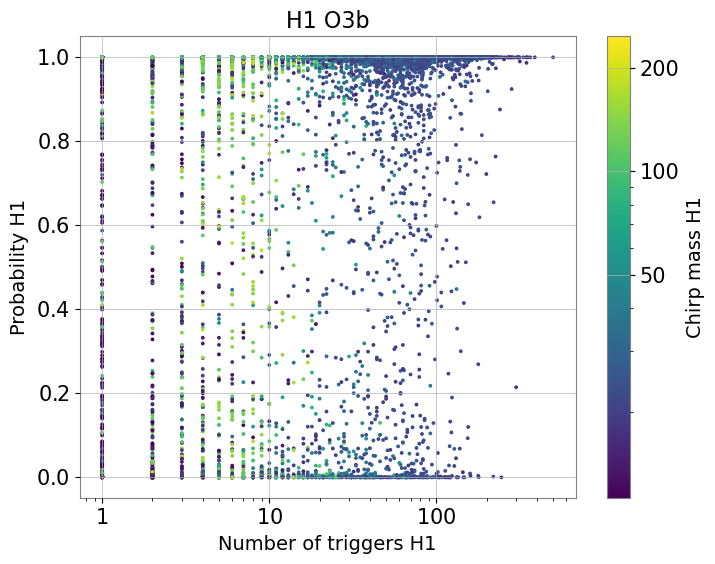

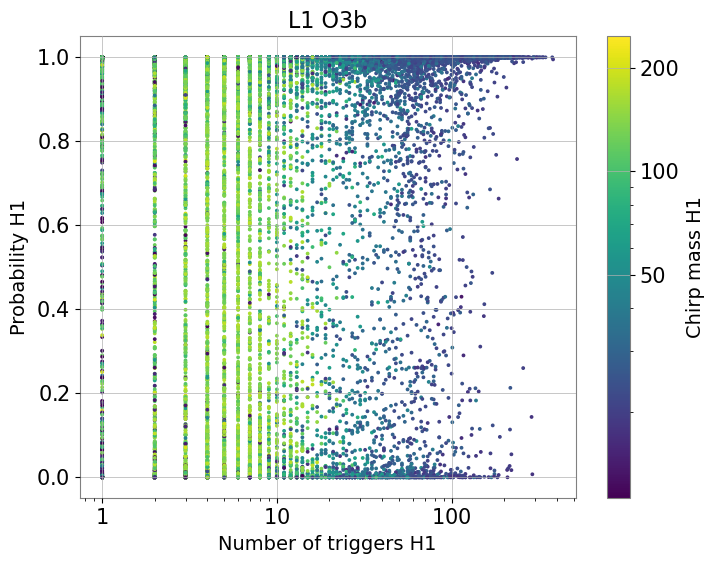

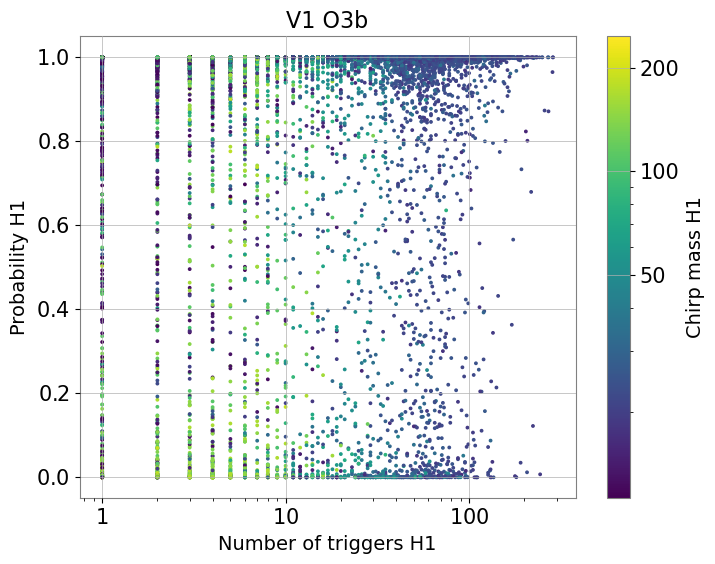

In [177]:
for data, ifo in zip([dataH1, dataL1, dataV1], ['H1', 'L1', 'V1']):

    chirpmass = (data['Mass_1'] * data['Mass_2'])**(3/5)/(data['Mass_1']+data['Mass_2'])**(1/5)
    plt.scatter(data['Num_triggers'], data['ProbInj'], c=chirpmass,norm=matplotlib.colors.LogNorm(), s=3) 

    cbar = plt.colorbar(label='Chirp mass H1')
    cbar.set_ticks([10, 50, 100, 200])
    cbar.set_ticklabels([10, 50, 100, 200])
    plt.xscale('log')
    plt.xlabel('Number of triggers H1')
    plt.ylabel('Probability H1')
    plt.title(ifo + ' ' + run)
    plt.show()

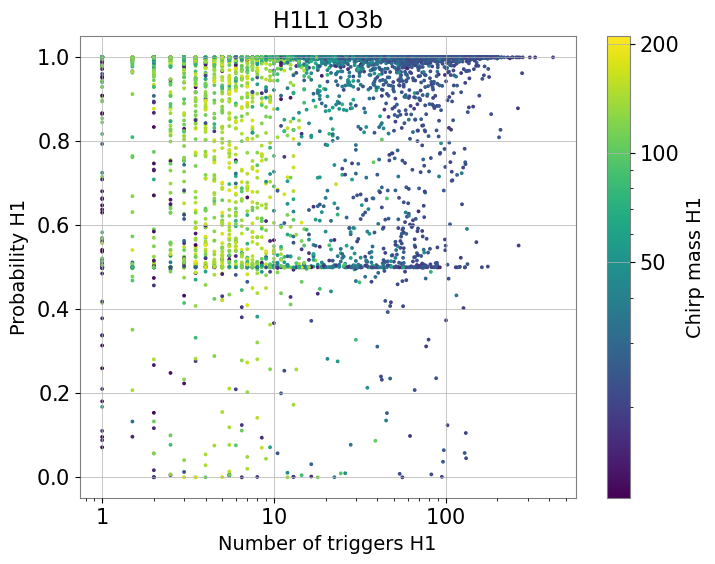

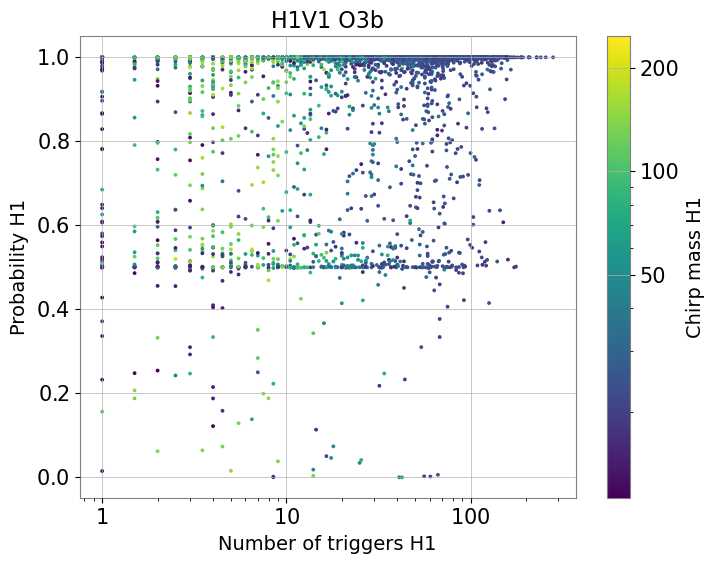

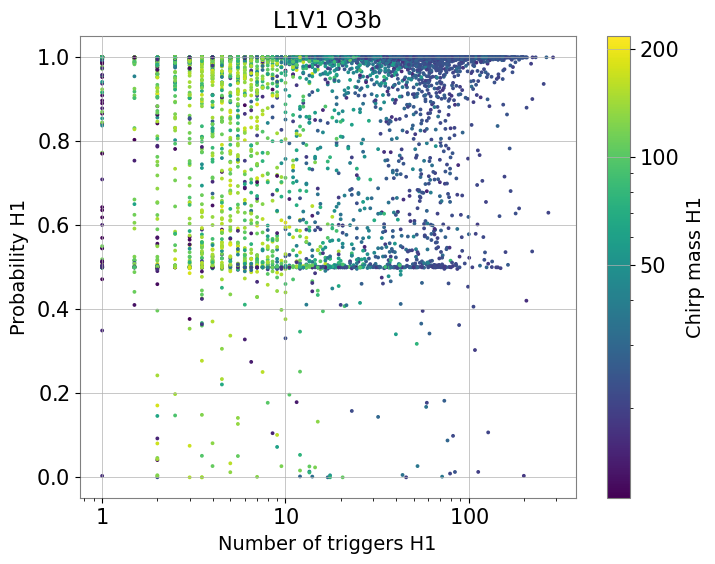

In [178]:
for data, ifos in zip([dataH1L1, dataH1V1, dataL1V1], ['H1L1', 'H1V1', 'L1V1']):
    ifo1, ifo2 = ifos[:2], ifos[-2:]
    avchirp = avChirpMass(data, ifo1, ifo2)
    avprob = (data['ProbInj_'+ifo1]+data['ProbInj_'+ifo2])/2
    avtrig = (data['Num_triggers_'+ifo1]+data['Num_triggers_'+ifo2])/2

    plt.scatter(avtrig, avprob, c=avchirp,norm=matplotlib.colors.LogNorm(), s=3) 

    cbar = plt.colorbar(label='Chirp mass H1')
    cbar.set_ticks([10, 50, 100, 200])
    cbar.set_ticklabels([10, 50, 100, 200])
    plt.xscale('log')
    plt.xlabel('Number of triggers H1')
    plt.ylabel('Probability H1')
    plt.title(ifos + ' ' + run)
    plt.show()

Text(0, 0.5, 'Probability H1')

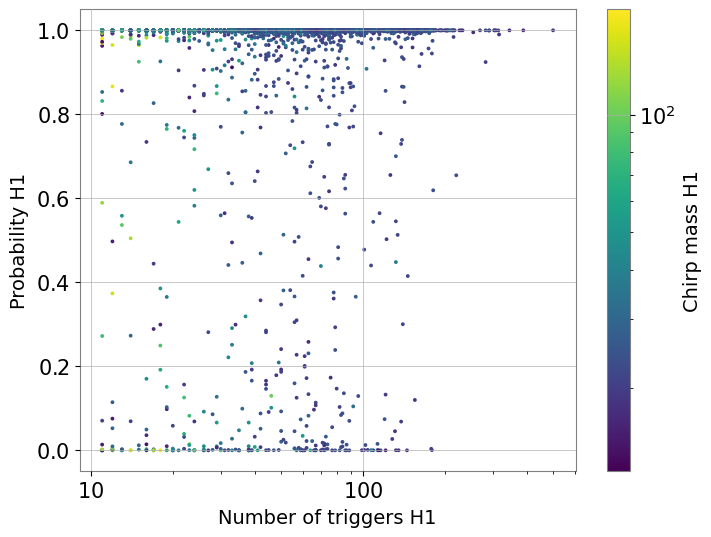

In [36]:
chirpmass = (cond2_['Mass_1_H1']*cond2_['Mass_2_H1'])**(3/5)/(cond2_['Mass_1_H1']+cond2_['Mass_2_H1'])**(1/5)
plt.scatter(cond2_['Num_triggers_H1'], cond2_['ProbInj_H1'], c=chirpmass, s=3, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Chirp mass H1')
plt.xscale('log')
plt.xlabel('Number of triggers H1')
plt.ylabel('Probability H1')

0 1268630422.6318164 2.33527988058313e-08 3.6651628761319444e-05 133.0


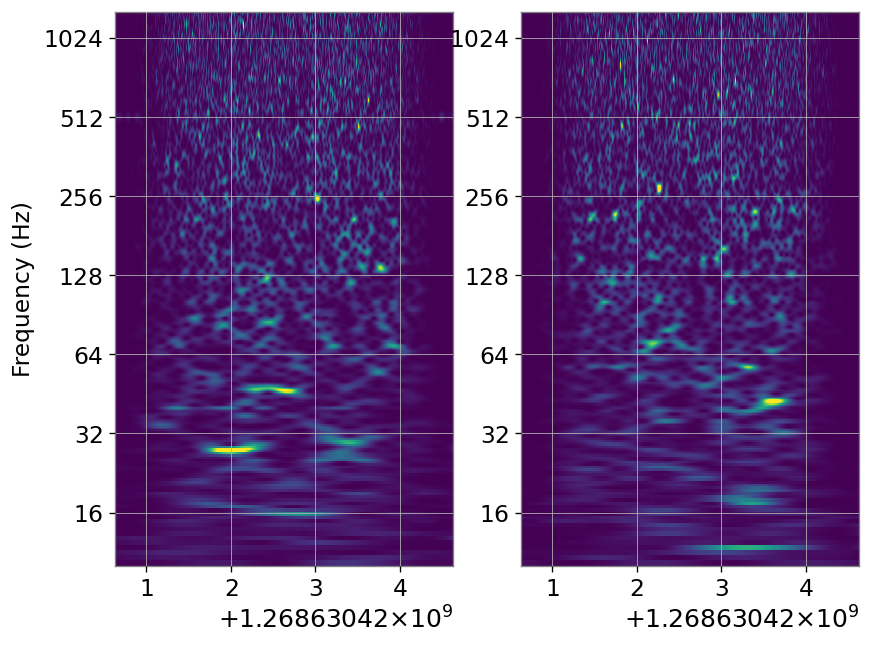

1 1260409671.8367393 6.408416811609641e-05 3.59358626189632e-10 21.0


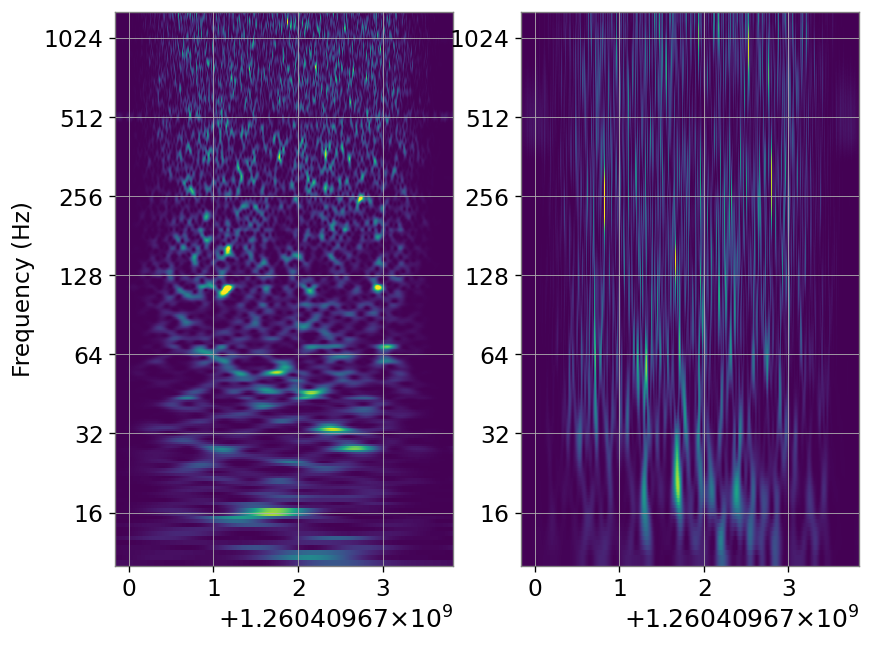

2 1259051031.7094696 9.349603351438418e-05 7.796650606906042e-05 18.0


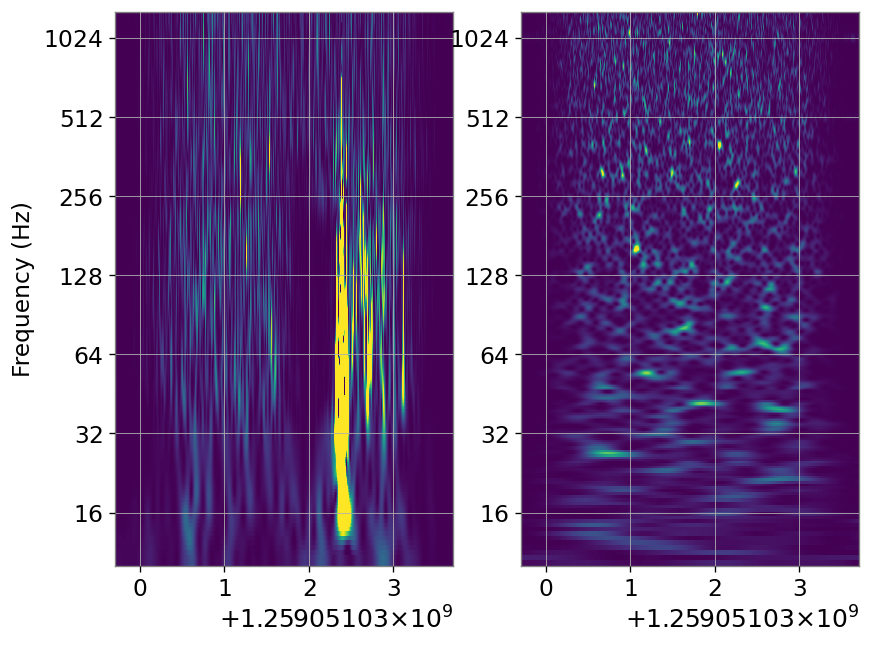

3 1263128587.875193 7.89106024967623e-09 0.00018055766122415662 18.0


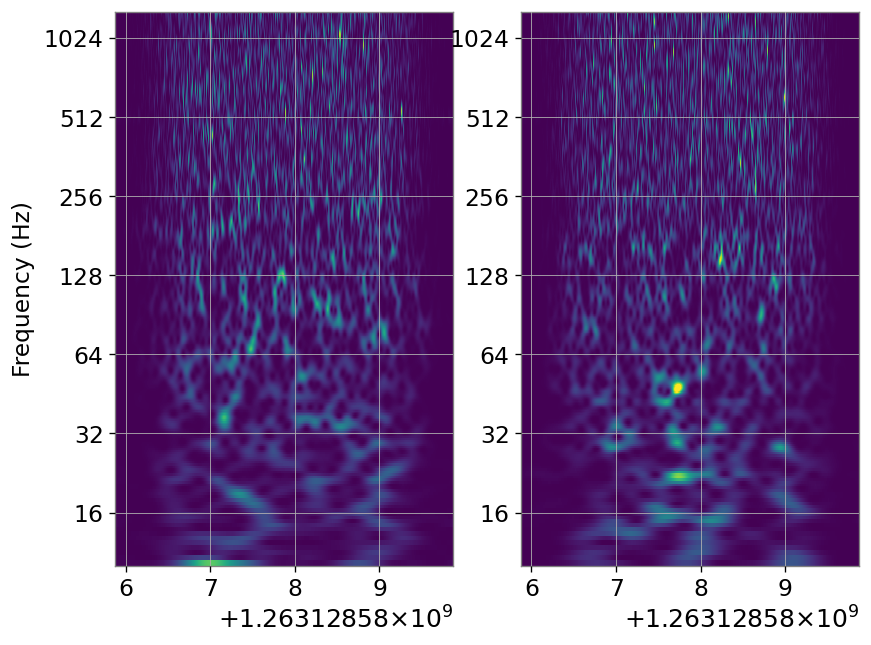

4 1261657038.4347937 7.631677726749331e-05 0.0004670501803047955 55.0


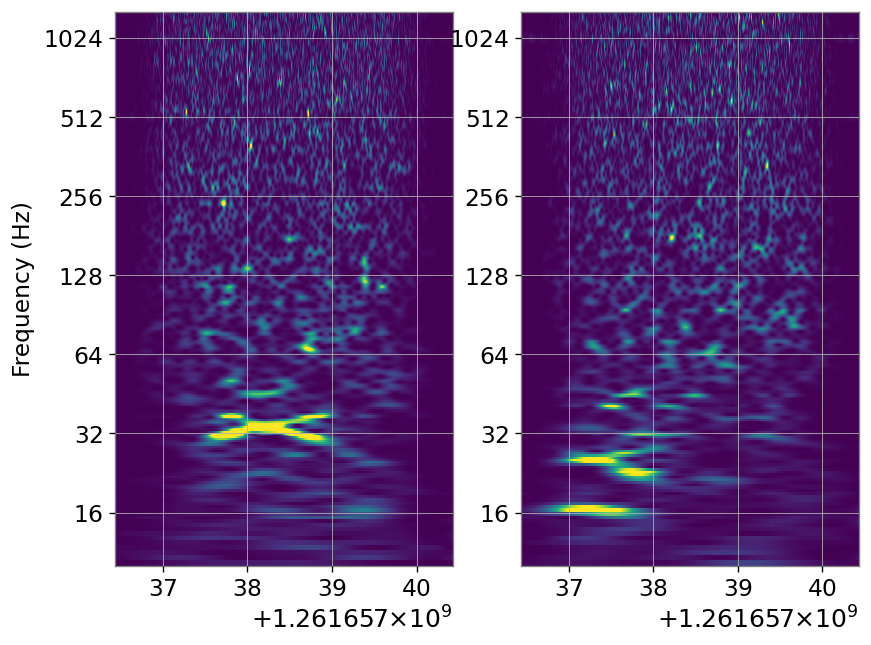

5 1259865256.3940277 0.0022922337520867586 4.951345545123331e-06 17.0


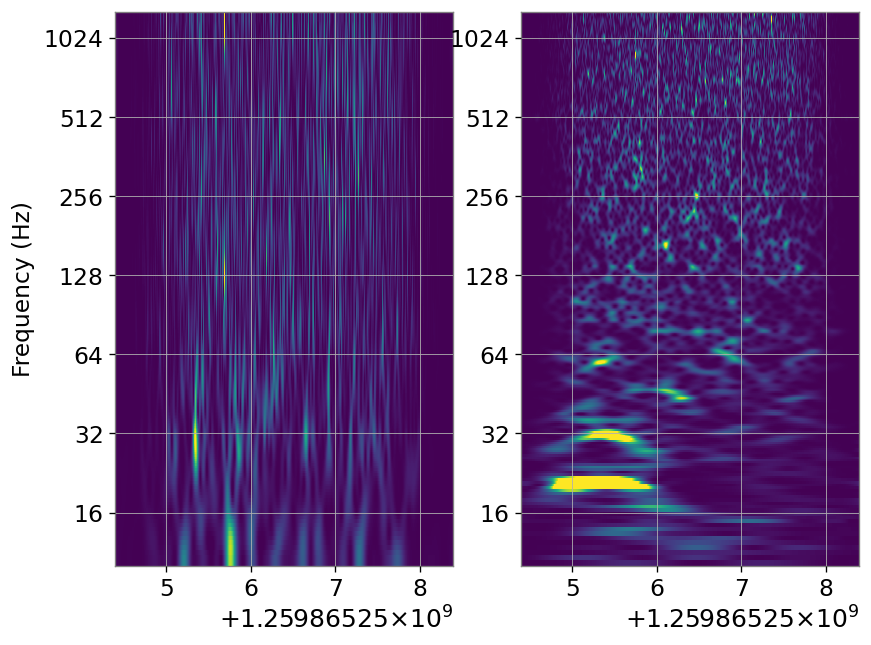

6 1260363719.056629 0.00027537153800949454 0.002118983305990696 20.0


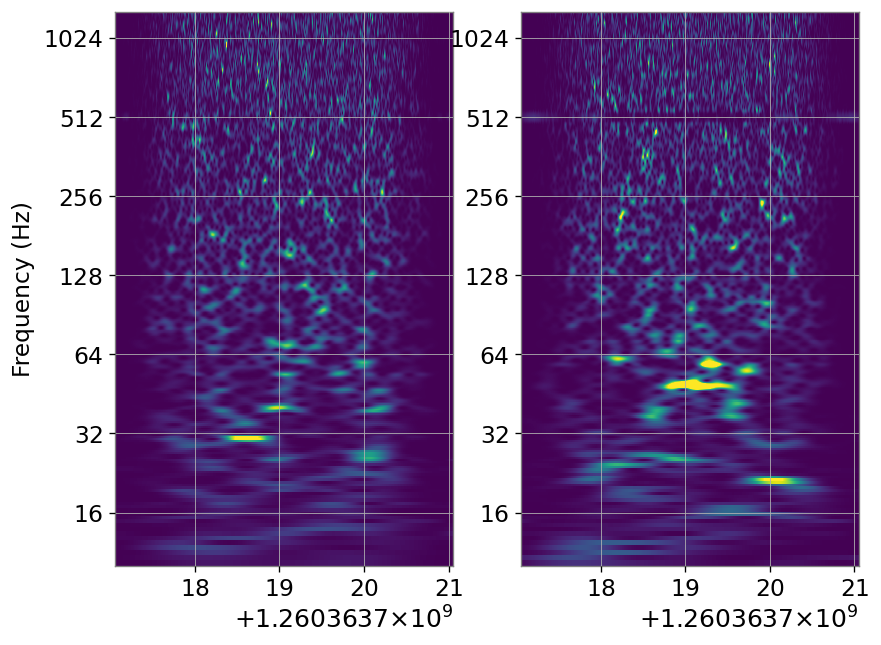

7 1266318757.8569615 0.0024390274193137884 8.33396115922369e-05 20.0


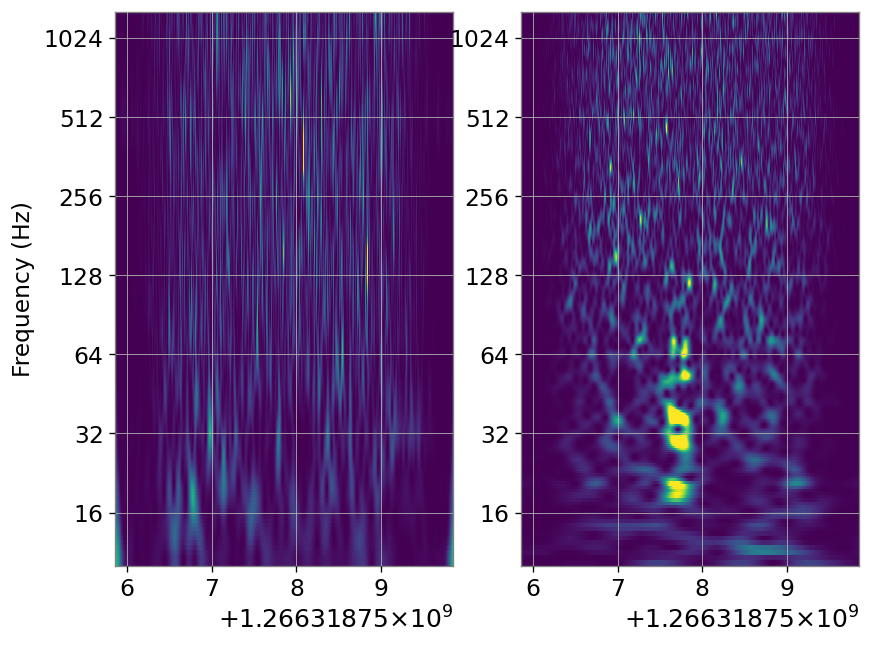

8 1263826798.045756 3.8836972748867993e-07 0.010175198316574097 25.0


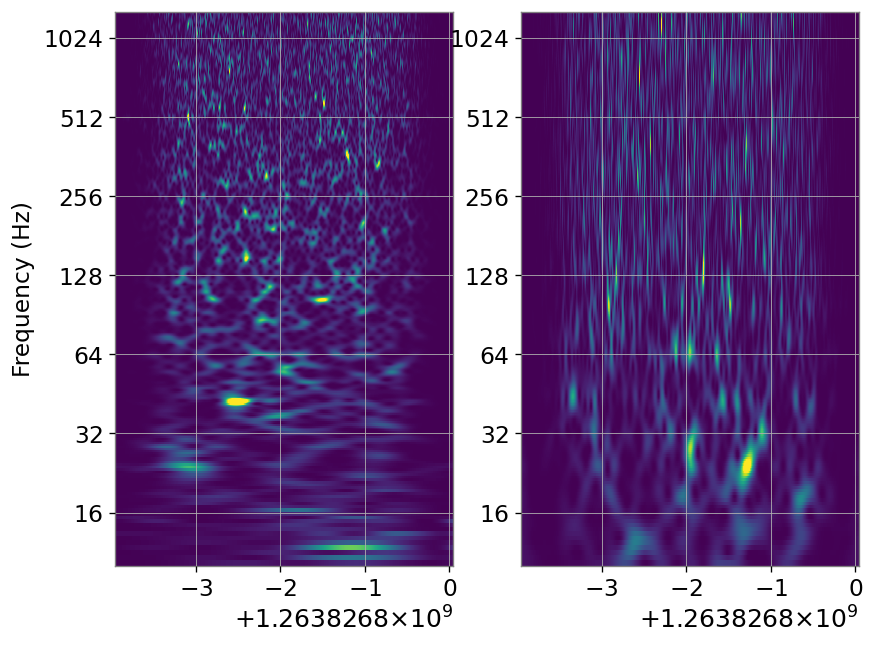

9 1261035998.0318675 8.85596485034057e-09 0.014032725244760513 21.0


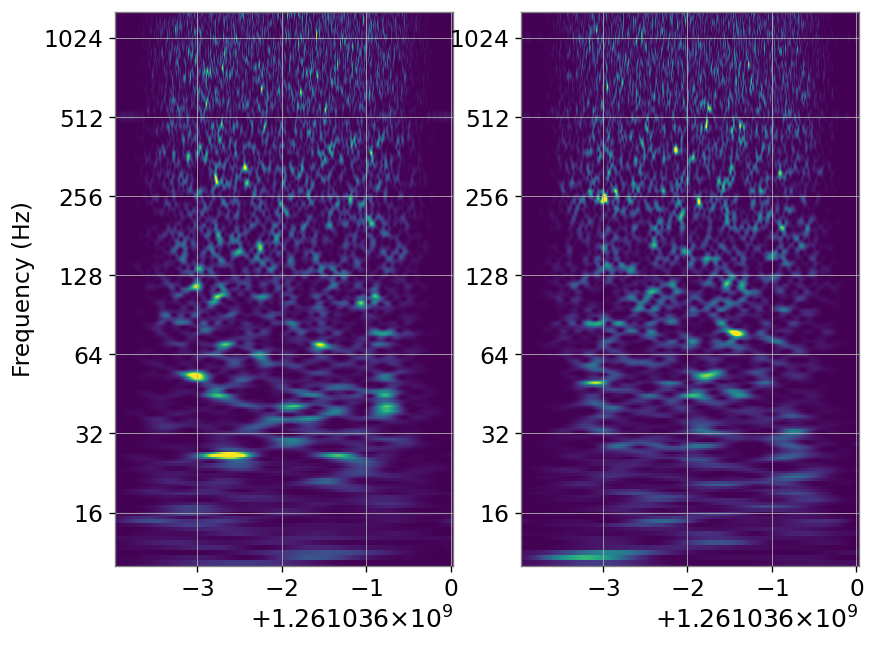

In [30]:
chirpmass = (cond2_['Mass_1_H1']*cond2_['Mass_2_H1'])**(3/5)/(cond2_['Mass_1_H1']+cond2_['Mass_2_H1'])**(1/5)
for t in range(10):
    t_star = cond2_.iloc[t]['Cluster_times_'+ifo]
    print(t, t_star,
          cond2_.iloc[t]['ProbInj_H1'], cond2_.iloc[t]['ProbInj_L1'],
          np.round(chirpmass.iloc[t]))
    fig, ax = plt.subplots(1, 2, dpi=120)
    for i, ifo in enumerate(['H1', 'L1']):
        strain = TimeSeries.fetch_open_data(ifo, t_star - 2, t_star + 2)
        # Perform q-transform
        q_scan = strain.q_transform(qrange=[4, 64], frange=[10, 2048],
                                 tres=0.002, fres=0.5, whiten=True)

        # Plot spectrogram
        ax[i].imshow(q_scan, cmap='viridis', vmin=0, vmax=25.5,label=ifo)
        ax[i].set_yscale('log', base=2)
        ax[i].set_xscale('linear')
        ax[0].set_ylabel('Frequency (Hz)', fontsize=14)
        #ax[i].set_xlabel('Time (s)', labelpad=0.1, fontsize=14)
        ax[i].yaxis.set_major_formatter(ScalarFormatter())
        ax[i].tick_params(axis='both', which='major', labelsize=14)
    plt.show()

## Glitches

Note that we do this computation for O3b data only

In [34]:
tw = 0.05
run = 'O3b'
path = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'

columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class', 'Num_triggers', 'Cluster_ID', 'Cluster_times']

# Load data input to MLP
dataH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + ".npy")
dataL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + ".npy")
dataV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + ".npy")

print(dataH1.shape)
# Compute predictions
ypredH1, ypredL1, ypredV1 = getKnownPredictions(dataH1[:, :-1], run, tw, 'H1'), getKnownPredictions(dataL1[:, :-1], run, tw, 'L1'), getKnownPredictions(dataV1[:, :-1], run, tw, 'V1')

# Load times
timesH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + "_IDs.npy")
timesL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + "_IDs.npy")
timesV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + "_IDs.npy")

# Merge everything and label
dataH1 = pd.merge(pd.DataFrame(dataH1), pd.DataFrame(timesH1),
                  left_index=True, right_index=True)
dataL1 = pd.merge(pd.DataFrame(dataL1), pd.DataFrame(timesL1),
                  left_index=True, right_index=True)
dataV1 = pd.merge(pd.DataFrame(dataV1), pd.DataFrame(timesV1),
                  left_index=True, right_index=True)
dataH1.columns, dataL1.columns, dataV1.columns = columns, columns, columns

# Merge predictions with data
dataH1, dataL1, dataV1 = pd.DataFrame(dataH1, columns=columns), pd.DataFrame(dataL1, columns=columns), pd.DataFrame(dataV1, columns=columns)
dataH1['ProbInj'], dataL1['ProbInj'], dataV1['ProbInj'] = ypredH1[:, 0], ypredL1[:, 0], ypredV1[:, 0]
#dataH1, dataL1, dataV1 = dataH1.loc[dataH1['Class'] == 0], dataL1.loc[dataL1['Class'] == 0], dataV1.loc[dataV1['Class'] == 0]
dataH1, dataL1, dataV1 = dataH1.reset_index(drop=True), dataL1.reset_index(drop=True), dataV1.reset_index(drop=True)
# We drop duplicates due to boostrapping oversample
dataH1, dataL1, dataV1 = dataH1.drop_duplicates(), dataL1.drop_duplicates(), dataV1.drop_duplicates() 

(153300, 8)
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


153300
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
301700
99.05Acc_V1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2382epochs_10batches.pth
175200


We compute double coincidence and tripple coincidence of the detectors

In [7]:
dataH1L1 = doubleCoincidence(dataH1, dataL1, 'H1', 'L1')
dataH1V1 = doubleCoincidence(dataH1, dataV1, 'H1', 'V1')
dataL1V1 = doubleCoincidence(dataL1, dataV1, 'L1', 'V1')
dataH1L1V1 = tripleCoincidence(dataH1, dataL1, dataV1, 'H1', 'L1', 'V1')

22
22
22
33


In [128]:
!pip install adjustText

Text(0.5, 1.0, 'Double coincidence O3b')

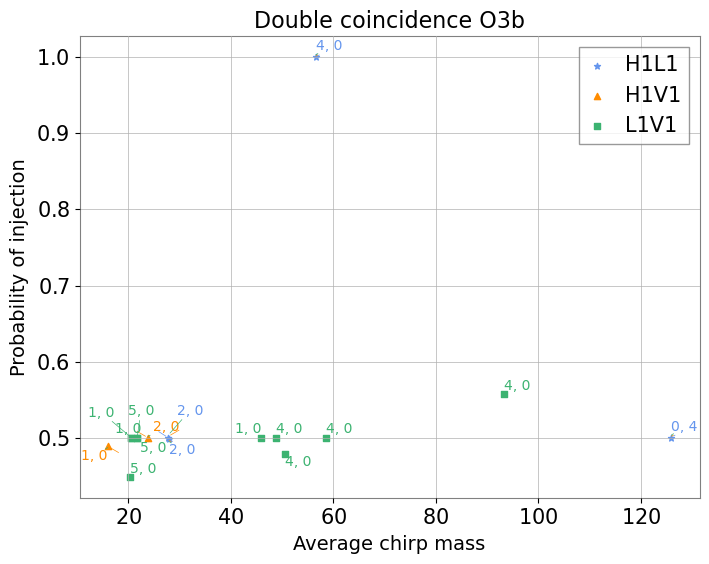

In [136]:
tmp_ifo = np.vstack([tmp_df['IFO1'].values, tmp_df['IFO2'].values])
texts = list()
for ifos_, data in zip(['H1L1', 'H1V1', 'L1V1'], [dataH1L1, dataH1V1, dataL1V1]):
    k = 0
    if ifos_ == 'H1L1':
        marker, color = '*', 'cornflowerblue'; deltax, deltay = 0, -0.02
    
    if ifos_ == 'H1V1':
        marker, color = '^', 'darkorange';  deltax, deltay = 0, 0
        
    if ifos_ == 'L1V1':
        marker, color = 's', 'mediumseagreen'; deltax, deltay = 0, 0.02
  
    ifo1, ifo2 = ifos_[:2], ifos_[-2:]
    for c1, c2 in product(np.arange(0, 6), np.arange(0, 6)):
        if (c1 == 0) and (c2 == 0):
            pass
        else:

            tmp = data.loc[(data['Class_'+ifo1]==c1) & (data['Class_'+ifo2]==c2)]
            tmp = tmp.drop_duplicates()
            if len(tmp) != 0:
                chirp1 = (tmp['Mass_1_'+ifo1] * tmp['Mass_2_'+ifo1])**(3/5)/(tmp['Mass_1_'+ifo1]+tmp['Mass_2_'+ifo1])**(1/5)
                chirp2 = (tmp['Mass_1_'+ifo2] * tmp['Mass_2_'+ifo2])**(3/5)/(tmp['Mass_1_'+ifo2]+tmp['Mass_2_'+ifo2])**(1/5)
                x = (chirp1 + chirp2)/2
                y = (tmp['ProbInj_'+ifo1] + tmp['ProbInj_'+ifo2])/2
                
                if k == 0:
                    plt.scatter(x, 
                            y, s=20, marker=marker, c=color, label=ifos_)
                else:
                    plt.scatter(x, 
                                y, s=20, marker=marker, c=color)
                for k in range(len(x)):
                    lists = str(tmp['Class_'+ifo1].values.astype(int)[k])+', '+ str(tmp['Class_'+ifo2].values.astype(int)[k])
   
                    texts.append(plt.text(x.values[k], y.values[k], 
                             str(tmp['Class_'+ifo1].values.astype(int)[k])+', '+ str(tmp['Class_'+ifo2].values.astype(int)[k]),
                             size=10, color=color))
                k = k + 1
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color=color, lw=0.5))
    
plt.xlabel('Average chirp mass')
plt.ylabel('Probability of injection')
plt.legend()
plt.title('Double coincidence O3b')


'Injections': 0

'Blip': 1

'Koi_Fish':  2

'Low_Frequency_Burst': 3

'Tomte': 4

'Whistle': 5

'Fast_Scattering': 6

In [65]:
str(tmp['Class_IFO1'].values.astype(int))+', '+ str(tmp['Class_IFO2'].values.astype(int))

'[0 2 4], [0 0 0]'

In [143]:
labels = np.stack([tmp_df['Class_L1'].values, tmp_df['Class_V1'].values], axis=1)
labels.astype(str)
labels[0]

array([0., 0.])

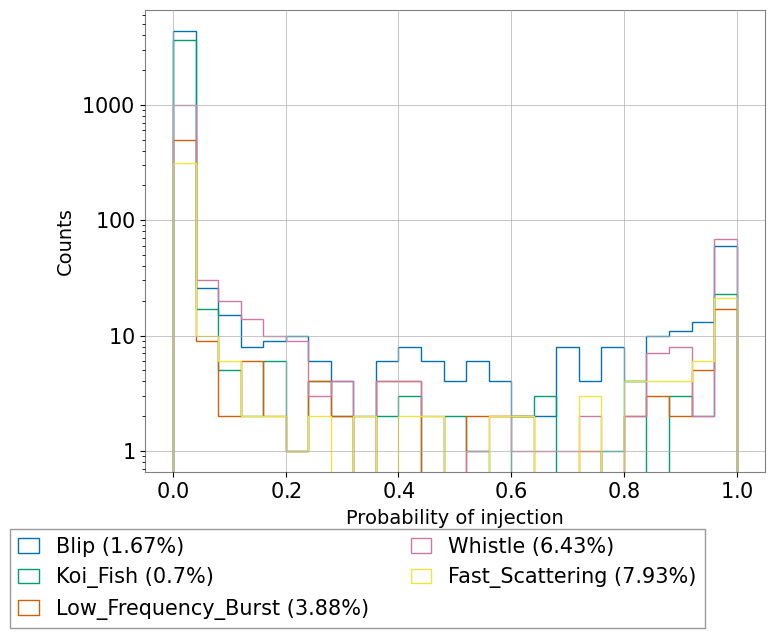

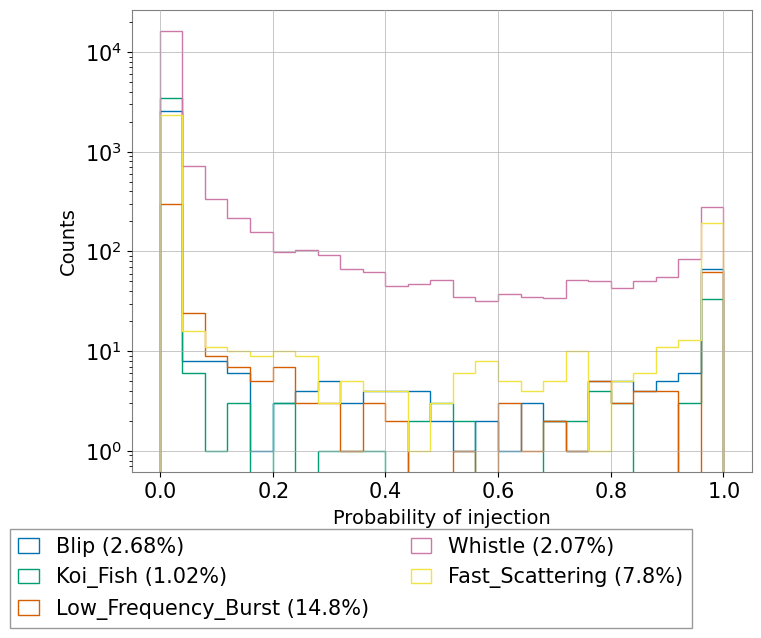

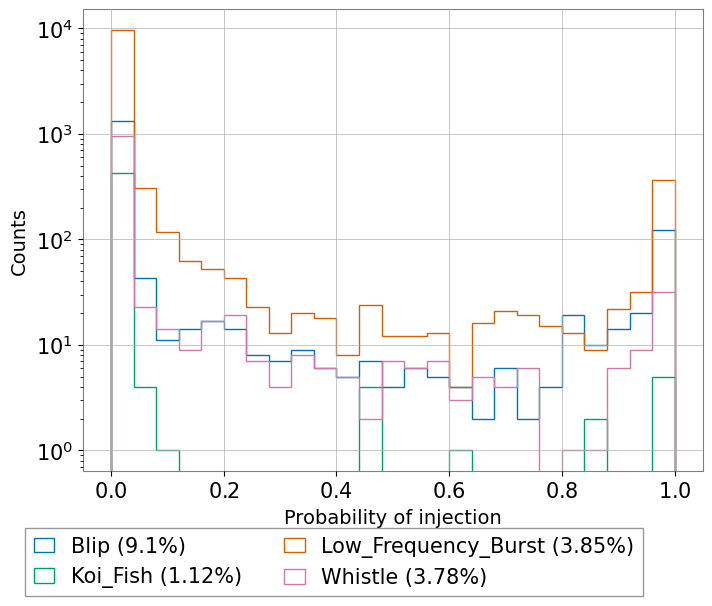

In [35]:
for ifo, data in zip(['H1', 'L1', 'V1'], [dataH1, dataL1, dataV1]):
    if ifo == 'V1':
        glts = ['Blip', 'Koi_Fish', 'Low_Frequency_Burst', 'Whistle']
    else:
        glts = ['Blip', 'Koi_Fish', 'Low_Frequency_Burst', 'Whistle', 'Fast_Scattering']

    for i, glt in enumerate(glts):

        num = np.round(len(data.loc[(data['Class'] == i+1) & (data['ProbInj'] > 0.9)])/len(data.loc[(data['Class'] == i+1)])*100, 2)
        plt.hist(data.loc[data['Class'] == i+1]['ProbInj'],
                 histtype='step', bins=25, label=glt + ' (' +str(num)+'%)')

    plt.yscale('log')
    plt.legend(bbox_to_anchor=[0.92, -0.1], ncol=2)
    plt.xlabel('Probability of injection')
    plt.ylabel('Counts')
    plt.show()

## Unknown data

In [32]:
tw = 0.05
ifo, run = 'H1', 'O3b'
path = '/data/gravwav/lopezm/Projects/GlitchBank/unknown_data/
print(path)
data = np.load(path + "dataset_all_" + ifo + "_bootstrap_" + run + ".npy")
data.shape

SyntaxError: EOL while scanning string literal (3921560434.py, line 3)

In [119]:
!ls /data/gravwav/lopezm/Projects/GlitchBank/unknown_data/

features_unknown_H1_0.05.csv  times_unknown_H1_0.05.csv
features_unknown_H1_0.1.csv   times_unknown_H1_0.1.csv
features_unknown_H1_0.2.csv   times_unknown_H1_0.2.csv
features_unknown_H1_0.5.csv   times_unknown_H1_0.5.csv
features_unknown_H1_1.csv     times_unknown_H1_1.csv
features_unknown_L1_0.05.csv  times_unknown_L1_0.05.csv
features_unknown_L1_0.1.csv   times_unknown_L1_0.1.csv
features_unknown_L1_0.2.csv   times_unknown_L1_0.2.csv
features_unknown_L1_0.5.csv   times_unknown_L1_0.5.csv
features_unknown_L1_1.csv     times_unknown_L1_1.csv
features_unknown_V1_0.05.csv  times_unknown_V1_0.05.csv
features_unknown_V1_0.1.csv   times_unknown_V1_0.1.csv
features_unknown_V1_0.2.csv   times_unknown_V1_0.2.csv
features_unknown_V1_0.5.csv   times_unknown_V1_0.5.csv
features_unknown_V1_1.csv     times_unknown_V1_1.csv


In [140]:
columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class', 'Num_triggers', 'Cluster_ID', 'Cluster_times']

# Load data input to MLP
dataH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + ".npy")
dataL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + ".npy")
dataV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + ".npy")

print(dataH1.shape)
# Compute predictions
ypredH1, ypredL1, ypredV1 = getKnownPredictions(dataH1[:, :-1], run, tw, 'H1'), getKnownPredictions(dataL1[:, :-1], run, tw, 'L1'), getKnownPredictions(dataV1[:, :-1], run, tw, 'V1')

# Load times
timesH1 = np.load(path + "dataset_all_" + 'H1' + "_bootstrap_" + run + "_IDs.npy")
timesL1 = np.load(path + "dataset_all_" + 'L1' + "_bootstrap_" + run + "_IDs.npy")
timesV1 = np.load(path + "dataset_all_" + 'V1' + "_bootstrap_" + run + "_IDs.npy")

# Merge everything and label
dataH1 = pd.merge(pd.DataFrame(dataH1), pd.DataFrame(timesH1),
                  left_index=True, right_index=True)
dataL1 = pd.merge(pd.DataFrame(dataL1), pd.DataFrame(timesL1),
                  left_index=True, right_index=True)
dataV1 = pd.merge(pd.DataFrame(dataV1), pd.DataFrame(timesV1),
                  left_index=True, right_index=True)
dataH1.columns, dataL1.columns, dataV1.columns = columns, columns, columns

# Merge predictions with data
dataH1, dataL1, dataV1 = pd.DataFrame(dataH1, columns=columns), pd.DataFrame(dataL1, columns=columns), pd.DataFrame(dataV1, columns=columns)
dataH1['ProbInj'], dataL1['ProbInj'], dataV1['ProbInj'] = ypredH1[:, 0], ypredL1[:, 0], ypredV1[:, 0]
dataH1, dataL1, dataV1 = dataH1.loc[dataH1['Class'] == 0], dataL1.loc[dataL1['Class'] == 0], dataV1.loc[dataV1['Class'] == 0]
dataH1, dataL1, dataV1 = dataH1.reset_index(drop=True), dataL1.reset_index(drop=True), dataV1.reset_index(drop=True)



((21900, 8), (43100, 8), (34223, 12))

In [76]:
getKnownPredictions(dataL1, run, tw, 'L1')



95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


301700


IndexError: index 153300 is out of bounds for axis 0 with size 153300

In [85]:
X_test, y_test = prepareData(dataL1, run)
model = load_model(tw, ifo)

X, y = X_test, np.ones(len(X_test))
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

unknown_data = TensorDataset(X, y)
unknown_dataloader = DataLoader(unknown_data, batch_size=len(unknown_data))

k = 0
for x_, y_ in unknown_dataloader:
    # Forward pass
    pred = model(x_)
    # get the predicted labels from the probabilities
    y_pred = nn.Softmax(dim=1)(pred)
    print(len(y_pred))
    pred_labels = list()
    for i in range(len(y_pred)):
        if y_pred[i][0] >= threshold:
            label = 0
        else: 
            # plus one moves the label naming
            label = np.argmax(ypred[i][1:]) + 1
        pred_labels.append(label)
    pred_labels = np.asarray(pred_labels)
    pred_labels_max = torch.argmax(y_pred, dim = 1) 



95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth


/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


30170


IndexError: index 15330 is out of bounds for axis 0 with size 15330

In [113]:
ypred

array([[2.2656654e-03, 0.0000000e+00, 2.3001170e-32, ..., 1.1133571e-02,
        0.0000000e+00, 9.8660082e-01],
       [3.2784093e-16, 1.0000000e+00, 4.1350385e-26, ..., 0.0000000e+00,
        0.0000000e+00, 3.5272644e-40],
       [8.5141516e-01, 2.0815569e-13, 5.7307111e-25, ..., 2.2000621e-22,
        4.0499404e-25, 6.6178880e-09],
       ...,
       [1.8362562e-19, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [7.7135611e-04, 0.0000000e+00, 1.8889503e-42, ..., 9.7548884e-01,
        0.0000000e+00, 2.3739841e-02],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [114]:
for i in range(len(y_pred)):
    if i > 15328: 
        print(y_pred[i], i, len(y_pred))
    #np.argmax(ypred[i][1:])

tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2710e-28], grad_fn=<SelectBackward0>) 15329 30170
tensor([3.0150e-17, 1.0000e+00, 3.9032e-25, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.7564e-39], grad_fn=<SelectBackward0>) 15330 30170
tensor([9.9990e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8417e-23, 0.0000e+00,
        1.0035e-04], grad_fn=<SelectBackward0>) 15331 30170
tensor([1.0000e+00, 1.0278e-28, 2.8235e-16, 1.3563e-28, 0.0000e+00, 2.2138e-23,
        7.7251e-13], grad_fn=<SelectBackward0>) 15332 30170
tensor([1.3900e-20, 1.0000e+00, 1.0188e-15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3951e-19], grad_fn=<SelectBackward0>) 15333 30170
tensor([1.2807e-01, 0.0000e+00, 2.0226e-08, 2.6704e-07, 1.8596e-03, 0.0000e+00,
        8.7007e-01], grad_fn=<SelectBackward0>) 15334 30170
tensor([7.6524e-22, 1.0000e+00, 1.7558e-22, 0.0000e+00, 1.9717e-22, 0.0000e+00,
        2.3295e-12], grad_fn=<SelectBackward0>) 15335 30170
tensor([6.5514e-10, 

In [23]:
ypred[:, 0].shape

(153300,)

In [24]:
dData = pd.DataFrame(data, 
                     columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class'])
dData['ProbInj'] = ypred[:, 0]
dData = dData.loc[dData['Class'] == 0]

In [26]:
dData.columns

Index(['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class',
       'ProbInj'],
      dtype='object')

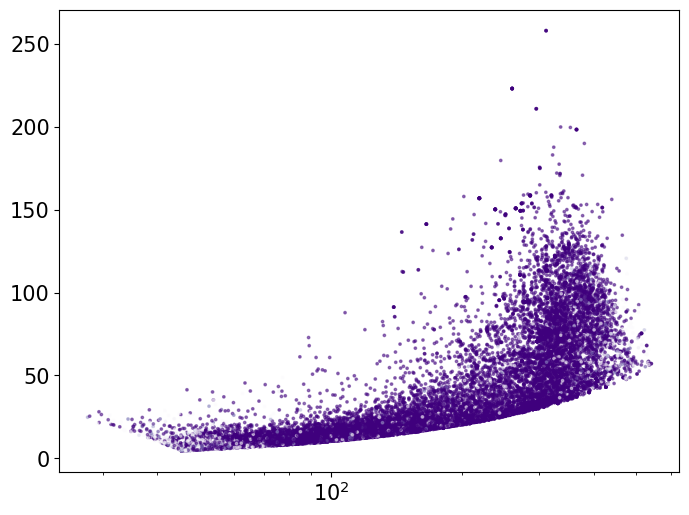

In [41]:
plt.scatter(dData['Mass_1'], dData['Mass_2'], c=dData['ProbInj'], s=3, alpha=0.5, cmap='Purples')
plt.xscale('log')

In [21]:
for ifo in ['H1', 'L1', 'V1']:
    df = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_'+ifo+'.csv')
    df = df.sort_values(by='Cluster time')
    print(df.loc[(df['Cluster time'] > 1238303737.2)].iloc[0])

Unnamed: 0           8595.00
SNR                     4.10
Chisq                   0.97
Mass_1                139.35
Mass_2                 20.25
Spin1z                  0.64
Spin2z                 -0.08
Prob0                   1.00
Prob1                   0.00
Prob2                   0.00
Prob3                   0.00
Prob4                   0.00
Prob5                   0.00
Prob6                   0.00
Num triggers           15.00
Cluster ID           8595.00
Cluster time   1238303737.22
Name: 8595, dtype: float64
Unnamed: 0          12064.00
SNR                     6.43
Chisq                   0.78
Mass_1                156.10
Mass_2                 23.51
Spin1z                  0.70
Spin2z                 -0.11
Prob0                   1.00
Prob1                   0.00
Prob2                   0.00
Prob3                   0.00
Prob4                   0.00
Prob5                   0.00
Prob6                   0.00
Num triggers           18.00
Cluster ID          12064.00
Cluster time   1

In [ ]:
df.loc[(df['Prob0_'+ifo1]>0.9) & (df['Prob0_'+ifo2]>0.9)]

Unnamed: 0           8595.00
SNR                     4.10
Chisq                   0.97
Mass_1                139.35
Mass_2                 20.25
Spin1z                  0.64
Spin2z                 -0.08
Prob0                   1.00
Prob1                   0.00
Prob2                   0.00
Prob3                   0.00
Prob4                   0.00
Prob5                   0.00
Prob6                   0.00
Num triggers           15.00
Cluster ID           8595.00
Cluster time   1238303737.22
Name: 8595, dtype: float64